In [1]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image


from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'



# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)


In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted this line
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
class TripletDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = [item[1] for item in self.data_dir]

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        anchor, anchor_label = self.data_dir[idx]
        positive_idx = np.random.choice(len(self.data_dir))
        while self.labels[positive_idx] != anchor_label:
            positive_idx = np.random.choice(len(self.data_dir))
        positive, _ = self.data_dir[positive_idx]

        negative_idx = np.random.choice(len(self.data_dir))
        while self.labels[negative_idx] == anchor_label:
            negative_idx = np.random.choice(len(self.data_dir))
        negative, _ = self.data_dir[negative_idx]

        anchor = Image.fromarray(anchor.mul(255).byte().numpy().transpose((1, 2, 0)))
        positive = Image.fromarray(positive.mul(255).byte().numpy().transpose((1, 2, 0)))
        negative = Image.fromarray(negative.mul(255).byte().numpy().transpose((1, 2, 0)))

        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)

        return anchor, positive, negative


In [5]:
# Create triplet data loaders
triplet_trainset = TripletDataset(trainset, train_transforms)
triplet_trainloader = DataLoader(triplet_trainset, batch_size=32, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

criterion = nn.CrossEntropyLoss()


In [6]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0).mean()
        return loss

# Create the CNN model
cnn_model = CNNModel()
cnn_model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
triplet_loss = TripletLoss()

In [7]:
num_epochs = 100


# Lists to store training and validation losses and accuracies
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model_checkpoint_path = 'triplet_loss_model.pth'
# ...

# Inside your training loop
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0

    # ...

    for i, data in enumerate(tqdm(triplet_trainloader), 0):
        anchor, positive, negative = data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_output = cnn_model(anchor)
        positive_output = cnn_model(positive)
        negative_output = cnn_model(negative)

        loss = triplet_loss(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / (i + 1))

    torch.save(cnn_model.state_dict(), model_checkpoint_path)

    # Calculate training accuracy based on the margin
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for i, data in enumerate(tqdm(triplet_trainloader), 0):
            anchor, positive, negative = data
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            anchor_output = cnn_model(anchor)
            positive_output = cnn_model(positive)
            negative_output = cnn_model(negative)
            
            # Calculate the margin-based accuracy
            distance_positive = (anchor_output - positive_output).pow(2).sum(1)
            distance_negative = (anchor_output - negative_output).pow(2).sum(1)
            correct_train += torch.sum(distance_positive < distance_negative).item()
            total_train += anchor.size(0)

    train_accuracies.append(correct_train / total_train)
   
   #validation loop using cross enthropy 

    cnn_model.eval()
    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)  # Use Cross-Entropy Loss

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_losses.append(running_loss / (i + 1))
    valid_accuracies.append(correct_valid / total_valid)

    print(f"Epoch {epoch + 1}, Loss: {train_losses[-1]}, Training Acc: {train_accuracies[-1]}, Validation Acc: {valid_accuracies[-1]}")

# ...

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Validation Loss': valid_losses,
    'Validation Accuracy': valid_accuracies
})

# Save the DataFrame to a CSV file
csv_file = 'triplet_loss_function_metrics.csv'
df.to_csv(csv_file, index=False)

100%|██████████| 205/205 [02:20<00:00,  1.45it/s]


Epoch 1, Loss: 4.96519252003693, Training Acc: 0.4942002442002442, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:36<00:00,  1.31it/s]


Epoch 2, Loss: 1.0000029572626439, Training Acc: 0.498015873015873, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:31<00:00,  1.35it/s]


Epoch 3, Loss: 0.9999905004733947, Training Acc: 0.5064102564102564, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:33<00:00,  1.34it/s]


Epoch 4, Loss: 1.000943037358726, Training Acc: 0.5128205128205128, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:30<00:00,  1.36it/s]


Epoch 5, Loss: 1.0000108564772257, Training Acc: 0.49664224664224665, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:18<00:00,  1.48it/s]


Epoch 6, Loss: 0.9999939688822118, Training Acc: 0.49694749694749696, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:19<00:00,  1.47it/s]


Epoch 7, Loss: 1.0000070676570985, Training Acc: 0.4902319902319902, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 8, Loss: 1.0000300160268458, Training Acc: 0.4946581196581197, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 9, Loss: 0.9999661748002215, Training Acc: 0.49984737484737485, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 10, Loss: 1.0000085694033924, Training Acc: 0.5106837606837606, Validation Acc: 0.017114914425427872


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 11, Loss: 0.999983360127705, Training Acc: 0.49252136752136755, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:19<00:00,  1.47it/s]


Epoch 12, Loss: 1.0000028706178432, Training Acc: 0.50503663003663, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 13, Loss: 0.9999874850598777, Training Acc: 0.5073260073260073, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 14, Loss: 0.9999705334989036, Training Acc: 0.5085470085470085, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:16<00:00,  1.51it/s]


Epoch 15, Loss: 1.0001961190526079, Training Acc: 0.4993894993894994, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:12<00:00,  1.55it/s]


Epoch 16, Loss: 1.0000871870575883, Training Acc: 0.5041208791208791, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 17, Loss: 0.9999896982821023, Training Acc: 0.5045787545787546, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:16<00:00,  1.51it/s]


Epoch 18, Loss: 1.0000262539561202, Training Acc: 0.49694749694749696, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 19, Loss: 1.0000100115450417, Training Acc: 0.5067155067155067, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:15<00:00,  1.52it/s]


Epoch 20, Loss: 1.0000151884265063, Training Acc: 0.49175824175824173, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 21, Loss: 0.9999972134101681, Training Acc: 0.5, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 22, Loss: 0.9999219243119403, Training Acc: 0.49542124542124544, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 23, Loss: 1.0000720088074846, Training Acc: 0.49984737484737485, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:12<00:00,  1.55it/s]


Epoch 24, Loss: 1.000027375395705, Training Acc: 0.4983211233211233, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 25, Loss: 0.9999892984948507, Training Acc: 0.4946581196581197, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 26, Loss: 1.0000817310519334, Training Acc: 0.4896214896214896, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 27, Loss: 1.000010790475985, Training Acc: 0.49633699633699635, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 28, Loss: 0.9997543701311437, Training Acc: 0.5044261294261294, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 29, Loss: 1.0000348881977361, Training Acc: 0.5006105006105006, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 30, Loss: 1.0003099485141476, Training Acc: 0.4938949938949939, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:11<00:00,  1.56it/s]


Epoch 31, Loss: 1.0003314684077007, Training Acc: 0.489010989010989, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 32, Loss: 0.9991661016534015, Training Acc: 0.498015873015873, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:11<00:00,  1.55it/s]


Epoch 33, Loss: 0.999626560036729, Training Acc: 0.5004578754578755, Validation Acc: 0.01589242053789731


100%|██████████| 205/205 [02:11<00:00,  1.56it/s]


Epoch 34, Loss: 1.0002235313741172, Training Acc: 0.5007631257631258, Validation Acc: 0.01589242053789731


100%|██████████| 205/205 [02:11<00:00,  1.56it/s]


Epoch 35, Loss: 0.9994950649214954, Training Acc: 0.48687423687423687, Validation Acc: 0.01589242053789731


100%|██████████| 205/205 [02:11<00:00,  1.55it/s]


Epoch 36, Loss: 1.0007971714182597, Training Acc: 0.48855311355311354, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:11<00:00,  1.55it/s]


Epoch 37, Loss: 0.9975046541632675, Training Acc: 0.48443223443223443, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:11<00:00,  1.55it/s]


Epoch 38, Loss: 1.0018317527887297, Training Acc: 0.49145299145299143, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:12<00:00,  1.55it/s]


Epoch 39, Loss: 0.9985773371487129, Training Acc: 0.5015262515262515, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:12<00:00,  1.55it/s]


Epoch 40, Loss: 0.9986359477043152, Training Acc: 0.4938949938949939, Validation Acc: 0.022004889975550123


100%|██████████| 205/205 [02:12<00:00,  1.54it/s]


Epoch 41, Loss: 0.9948923898906242, Training Acc: 0.50503663003663, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 42, Loss: 1.0005654806044044, Training Acc: 0.5015262515262515, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:12<00:00,  1.54it/s]


Epoch 43, Loss: 1.0026138826114375, Training Acc: 0.49252136752136755, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:12<00:00,  1.55it/s]


Epoch 44, Loss: 1.0014501827519113, Training Acc: 0.489010989010989, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 45, Loss: 1.0023050860660832, Training Acc: 0.5088522588522588, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:12<00:00,  1.55it/s]


Epoch 46, Loss: 0.9988771078063221, Training Acc: 0.48443223443223443, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:11<00:00,  1.56it/s]


Epoch 47, Loss: 0.9961778629116895, Training Acc: 0.49786324786324787, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 48, Loss: 0.9958909901177011, Training Acc: 0.5074786324786325, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 49, Loss: 0.9991914318829048, Training Acc: 0.5018315018315018, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 50, Loss: 1.0015581308341608, Training Acc: 0.49175824175824173, Validation Acc: 0.0024449877750611247


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 51, Loss: 1.0004950549544358, Training Acc: 0.5071733821733821, Validation Acc: 0.022004889975550123


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 52, Loss: 1.0014213727741708, Training Acc: 0.492979242979243, Validation Acc: 0.022004889975550123


100%|██████████| 205/205 [02:16<00:00,  1.51it/s]


Epoch 53, Loss: 0.9939397643252117, Training Acc: 0.5, Validation Acc: 0.022004889975550123


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 54, Loss: 1.1539854357882244, Training Acc: 0.49099511599511597, Validation Acc: 0.01589242053789731


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 55, Loss: 1.0507454892484154, Training Acc: 0.5062576312576312, Validation Acc: 0.0012224938875305623


100%|██████████| 205/205 [02:27<00:00,  1.39it/s]


Epoch 56, Loss: 1.0028909886755595, Training Acc: 0.4946581196581197, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.51it/s]


Epoch 57, Loss: 1.0011082721919549, Training Acc: 0.5036630036630036, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 58, Loss: 0.9965992450714112, Training Acc: 0.4987789987789988, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 59, Loss: 0.999895642443401, Training Acc: 0.509004884004884, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 60, Loss: 1.0021693790831216, Training Acc: 0.5061050061050061, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 61, Loss: 0.9966418039507983, Training Acc: 0.5010683760683761, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 62, Loss: 0.9961593854718092, Training Acc: 0.4983211233211233, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 63, Loss: 1.0042017616876742, Training Acc: 0.5115995115995116, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.51it/s]


Epoch 64, Loss: 0.9978755264747433, Training Acc: 0.49542124542124544, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 65, Loss: 0.9979641658503835, Training Acc: 0.49496336996337, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 66, Loss: 0.9991784680180433, Training Acc: 0.49343711843711846, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:16<00:00,  1.50it/s]


Epoch 67, Loss: 0.9983739096943925, Training Acc: 0.49511599511599513, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 68, Loss: 1.00071583230321, Training Acc: 0.4958791208791209, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 69, Loss: 0.996094224220369, Training Acc: 0.49893162393162394, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.51it/s]


Epoch 70, Loss: 1.0028120154287756, Training Acc: 0.4945054945054945, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 71, Loss: 1.0043923866458055, Training Acc: 0.4993894993894994, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 72, Loss: 1.0008726021138634, Training Acc: 0.5167887667887668, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 73, Loss: 0.9981194914841071, Training Acc: 0.5051892551892552, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.52it/s]


Epoch 74, Loss: 1.0007276078549827, Training Acc: 0.4916056166056166, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:17<00:00,  1.49it/s]


Epoch 75, Loss: 1.0019456642430002, Training Acc: 0.5097680097680097, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 76, Loss: 0.9997888442946643, Training Acc: 0.48443223443223443, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 77, Loss: 0.999270134437375, Training Acc: 0.5054945054945055, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 78, Loss: 0.999790037259823, Training Acc: 0.5038156288156288, Validation Acc: 0.017114914425427872


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 79, Loss: 0.9996360470608967, Training Acc: 0.503052503052503, Validation Acc: 0.017114914425427872


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 80, Loss: 1.0039173079700006, Training Acc: 0.512057387057387, Validation Acc: 0.007334963325183374


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 81, Loss: 1.00158098674402, Training Acc: 0.5, Validation Acc: 0.007334963325183374


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 82, Loss: 1.0000394696142616, Training Acc: 0.49572649572649574, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 83, Loss: 0.9995750084155943, Training Acc: 0.5106837606837606, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 84, Loss: 1.000094219824163, Training Acc: 0.503052503052503, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 85, Loss: 0.9974784350976711, Training Acc: 0.49694749694749696, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 86, Loss: 1.000110951284083, Training Acc: 0.5028998778998779, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:15<00:00,  1.52it/s]


Epoch 87, Loss: 1.0004535611082868, Training Acc: 0.49862637362637363, Validation Acc: 0.019559902200488997


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 88, Loss: 1.0008175210254948, Training Acc: 0.4946581196581197, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 89, Loss: 1.0012712525158394, Training Acc: 0.5114468864468864, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 90, Loss: 0.99852307511539, Training Acc: 0.49572649572649574, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 91, Loss: 1.0009000327528976, Training Acc: 0.501984126984127, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 92, Loss: 0.9993321456560275, Training Acc: 0.49572649572649574, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.54it/s]


Epoch 93, Loss: 0.9991745410895929, Training Acc: 0.5045787545787546, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:13<00:00,  1.53it/s]


Epoch 94, Loss: 0.9957201259892161, Training Acc: 0.49511599511599513, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 95, Loss: 0.9987075480019174, Training Acc: 0.5067155067155067, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 96, Loss: 1.0011303087560142, Training Acc: 0.48977411477411475, Validation Acc: 0.008557457212713936


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 97, Loss: 1.0004822004132155, Training Acc: 0.5057997557997558, Validation Acc: 0.003667481662591687


100%|██████████| 205/205 [02:14<00:00,  1.52it/s]


Epoch 98, Loss: 1.0012769937515258, Training Acc: 0.4987789987789988, Validation Acc: 0.012224938875305624


100%|██████████| 205/205 [02:14<00:00,  1.53it/s]


Epoch 99, Loss: 1.0011221324525228, Training Acc: 0.501984126984127, Validation Acc: 0.012224938875305624


100%|██████████| 205/205 [02:12<00:00,  1.54it/s]


Epoch 100, Loss: 0.9999332491944476, Training Acc: 0.5006105006105006, Validation Acc: 0.006112469437652812


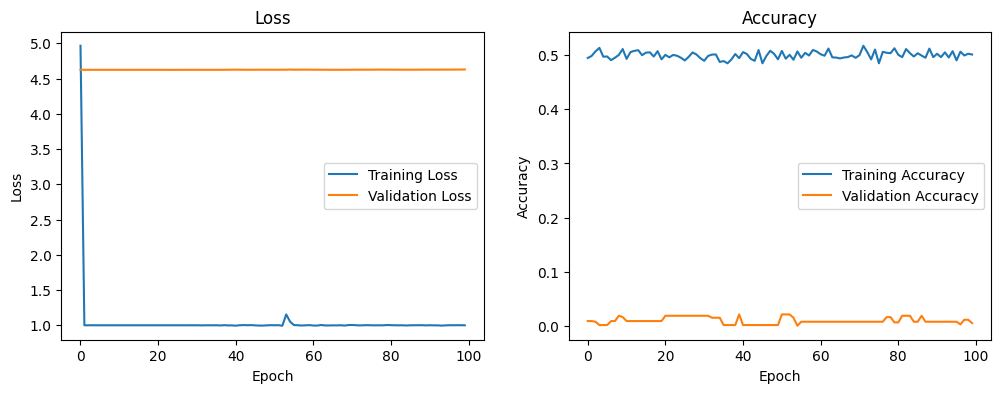

In [8]:
# After training, you can plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [9]:

# Create an instance of the CNNModel
model = CNNModel()

# Load the trained model's state dictionary
model.load_state_dict(torch.load('triplet_loss_model.pth'))
model.to(device)

# Switch the model to evaluation mode
model.eval()


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [10]:
# Load the model
model = CNNModel()
model.load_state_dict(torch.load('triplet_loss_model.pth'))
model.to(device)

# Print the model architecture
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


In [11]:
# Load the model
model = CNNModel()
model.load_state_dict(torch.load('triplet_loss_model.pth'))
model.to(device)

# Access the number of output features in the final classification layer (fc2)
num_classes = model.fc2.out_features

# Print the number of classes
print("Number of classes:", num_classes)


Number of classes: 102


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


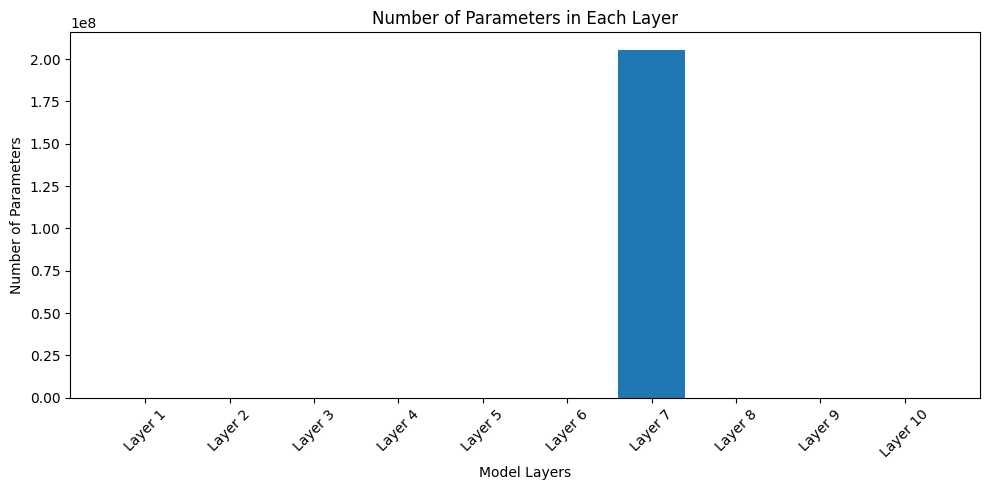

In [18]:
import matplotlib.pyplot as plt

# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()


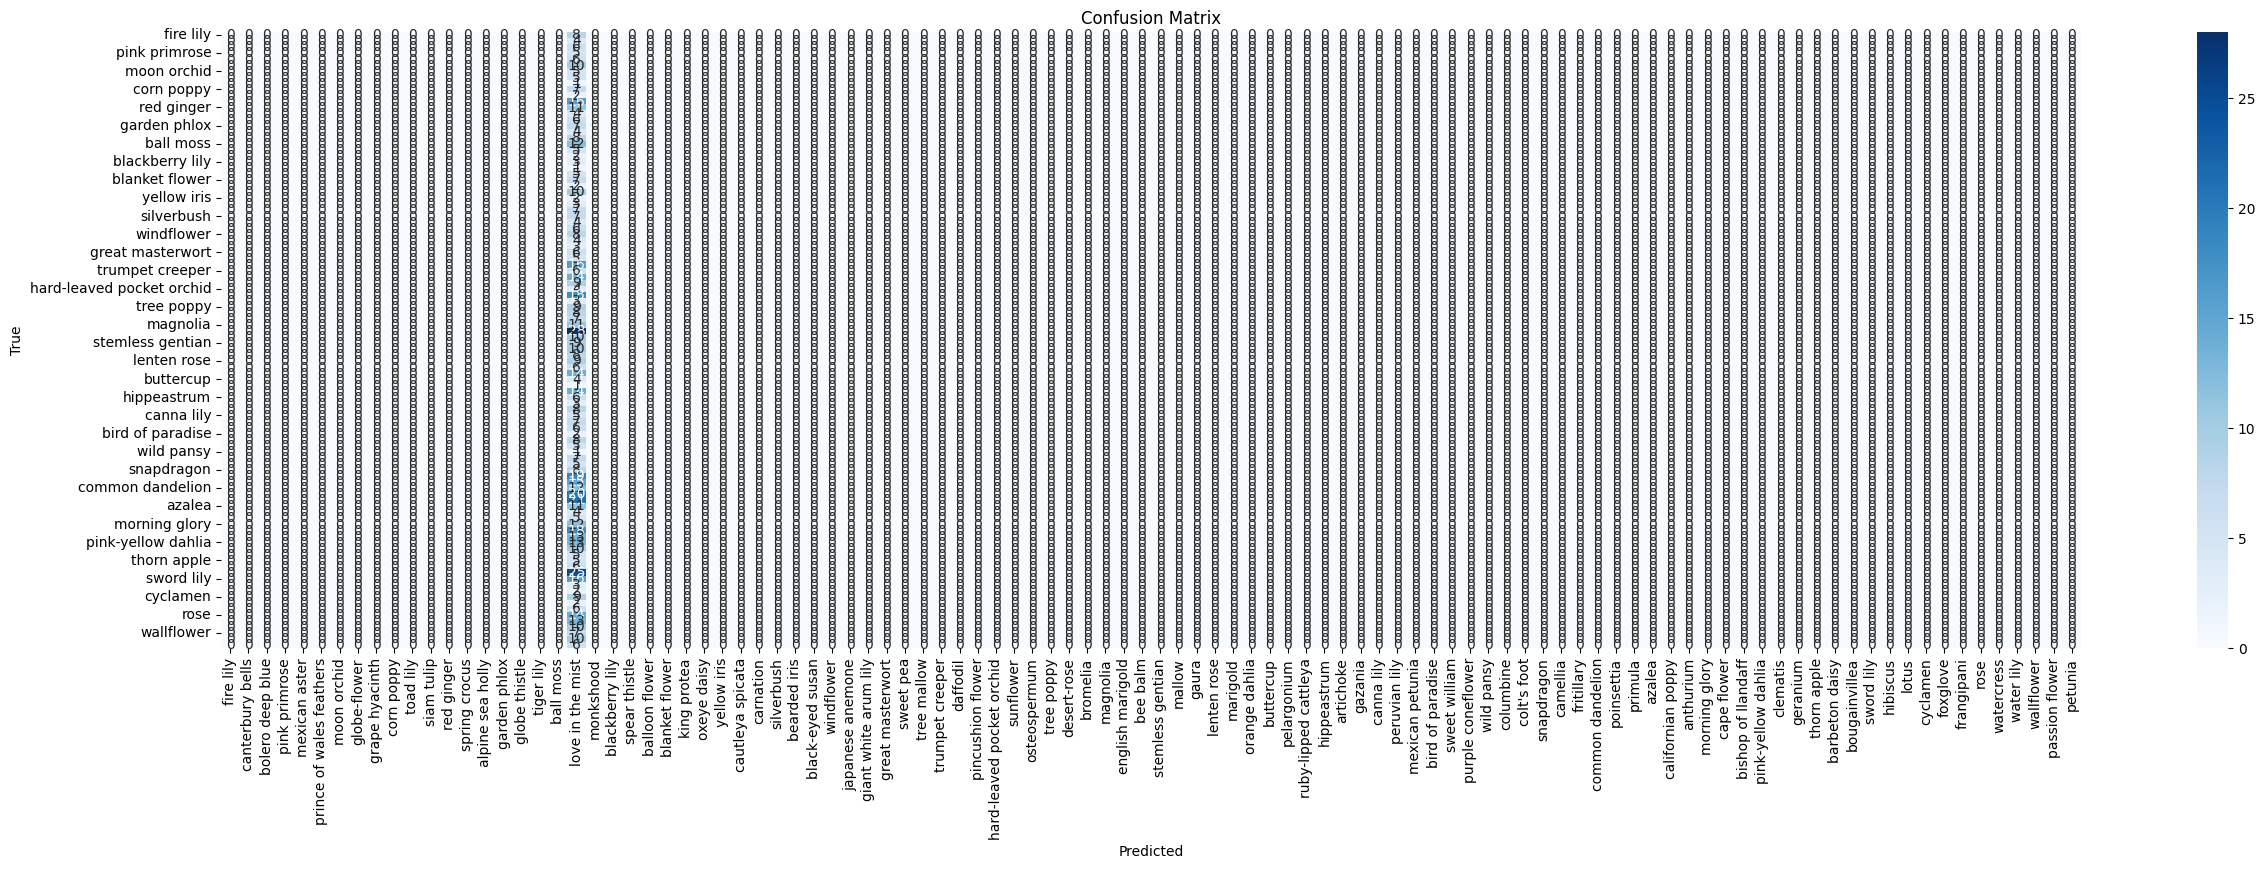

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(30, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
